## Linear Elastic Fracture Mechanics

In this notebook, we analyze the stress and displacement fields around a crack tip using Finite Element Method. We will use the LEFM (Linear Elastic Fracture Mechanics) theory to compare the results with the analytical solutions.


- Griffith’s criterion, \( G \) and \( G_c \)
- Stress field near crack tip

**In-Class Problem**

- Compute \( G \) in cracked vs uncracked bar (1D/2D)
- Compare FEM and analytical results

**Learning Outcome**

- Quantify fracture behavior from energy perspective


In [1]:
#| code-fold: true
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import jax.numpy as jnp
from jax import Array

import femsolver
from femsolver.utils import auto_vmap, vmap
from femsolver import Mesh, Operator, element
from femsolver.plotting import STYLE_PATH, colors

import gmsh
import numpy as np
import meshio

import equinox as eqx
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt

In [38]:
#| code-fold: true
#| output: false

def get_elements_on_curve(mesh, curve_func, tol=1e-3):
    coords = mesh.coords
    elements_2d = mesh.elements
    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return jnp.array([], dtype=int)
    
    return jnp.array(elements_1d)

def generate_cracked_plate_mesh(
    length: float,
    height: float,
    lc: float,
    min_elem: float,
    output_filename: str = "model.msh"
):
    """
    Generates a 2D mesh using the Gmsh Python API based on the provided .geo script.

    Args:
        length (float): Total length 'L' of the domain.
        height (float): Total height 'H' of the domain.
        lc (float): Characteristic length 'l' for the initial point.
        min_elem (float): Minimum element size for the refinement box.
        output_filename (str): Name of the output mesh file (e.g., 'model.msh').
    """
    gmsh.initialize()
    gmsh.model.add("refined_plate")

    # --- Use OpenCASCADE geometry kernel ---
    #gmsh.model.setFactory("OpenCASCADE")
    
    # --- Define script parameters ---
    h2 = 1.0
    epsilon = 1e-5
    depth = 0.0

    # --- Define geometry points ---
    # The last argument is the prescribed mesh size at that point.
    gmsh.model.geo.addPoint(0, epsilon, -depth / 2, h2, 1)
    gmsh.model.geo.addPoint(lc, 0, -depth / 2, h2, 2)
    gmsh.model.geo.addPoint(0, -epsilon, -depth / 2, h2, 6)
    gmsh.model.geo.addPoint(0, -height / 2, -depth / 2, h2, 7)
    gmsh.model.geo.addPoint(length, -height / 2, -depth / 2, h2, 8)
    gmsh.model.geo.addPoint(length, height / 2, -depth / 2, h2, 9)
    gmsh.model.geo.addPoint(0, height / 2, -depth / 2, h2, 10)
    gmsh.model.geo.addPoint(length, 0, -depth / 2, h2, 11)

    # --- Define lines connecting the points ---
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 11, 2)
    gmsh.model.geo.addLine(11, 9, 6)
    gmsh.model.geo.addLine(9, 10, 7)
    gmsh.model.geo.addLine(10, 1, 8)
    gmsh.model.geo.addLine(2, 6, 9)
    gmsh.model.geo.addLine(6, 7, 10)
    gmsh.model.geo.addLine(7, 8, 11)
    gmsh.model.geo.addLine(8, 11, 12)

    # --- Define curve loops and surfaces ---
    # A negative tag in a loop reverses the line's direction.
    gmsh.model.geo.addCurveLoop([1, 2, 6, 7, 8], 1)
    gmsh.model.geo.addCurveLoop([9, 10, 11, 12, -2], 2)
    
    gmsh.model.geo.addPlaneSurface([1], 1)
    gmsh.model.geo.addPlaneSurface([2], 2)

    # Synchronize the CAD kernel with the Gmsh model
    gmsh.model.geo.synchronize()

    # --- Define Physical Groups ---
    # Physical groups are used to identify boundaries and domains.
    # Physical Line(2) = {{2}};
    gmsh.model.addPhysicalGroup(1, [2], 2) # dim=1 for lines
    # Physical Surface(1) = {{1, 2}};
    gmsh.model.addPhysicalGroup(2, [1, 2], 1) # dim=2 for surfaces

    # --- Define Mesh Refinement Field ---
    # Create a 'Box' field to control mesh size in a specific region.
    field_tag = gmsh.model.mesh.field.add("Box")
    
    mesh_size_inside_box = min_elem
    mesh_size_outside_box = min_elem * 10
    
    gmsh.model.mesh.field.setNumber(field_tag, "VIn", mesh_size_inside_box)
    gmsh.model.mesh.field.setNumber(field_tag, "VOut", mesh_size_outside_box)
    
    gmsh.model.mesh.field.setNumber(field_tag, "XMin", 0)
    gmsh.model.mesh.field.setNumber(field_tag, "XMax", length)
    gmsh.model.mesh.field.setNumber(field_tag, "YMin", -height / 5)
    gmsh.model.mesh.field.setNumber(field_tag, "YMax", height / 5)
    gmsh.model.mesh.field.setNumber(field_tag, "ZMin", 0)
    gmsh.model.mesh.field.setNumber(field_tag, "ZMax", 0)
    gmsh.model.mesh.field.setNumber(field_tag, "Thickness", 2.5e-2)
    
    # Set this field as the background field, which Gmsh uses to drive mesh generation.
    gmsh.model.mesh.field.setAsBackgroundMesh(field_tag)

    # --- Set global mesh options ---
    # These options prevent Gmsh from overriding the background field.
    gmsh.option.setNumber("Mesh.CharacteristicLengthFromPoints", 0)
    gmsh.option.setNumber("Mesh.CharacteristicLengthFromCurvature", 0)
    gmsh.option.setNumber("Mesh.CharacteristicLengthExtendFromBoundary", 0)
    
    # --- Generate the 2D mesh ---
    gmsh.model.mesh.generate(2)

    # --- Save the mesh and optionally launch the GUI ---
    gmsh.write(output_filename)
    print(f"Mesh saved to '{output_filename}'")
    gmsh.finalize()


    _mesh = meshio.read(output_filename)

    #contact_nodes = _mesh.cell_sets_dict["Half-Circle Arc"]["line"]


    mesh = Mesh(
        coords=_mesh.points[:, :2],
        elements=_mesh.cells_dict["triangle"],
    )

    return mesh



We generate a plate with a crack of length $l_c$. We further refine the mesh near the crack tip and along the plane of symmetry.  

In [43]:
#| output: false

params = {
    "length": 0.1,
    "height": 0.02,
    "lc": 0.01,
    "min_elem": 1e-3,
    "output_filename": "refined_model.msh",
}

mesh = generate_cracked_plate_mesh(**params)


# get contact elements
# function identifies nodes on the line
def fracture_plane(coord: jnp.ndarray, tol: float) -> bool:
    return jnp.isclose(coord[1], 0, atol=tol)


fracture_elements = get_elements_on_curve(mesh, fracture_plane, tol=1e-6)
fracture_nodes = jnp.unique(fracture_elements.flatten())


n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 60%] Meshing curve 9 (Line)
Info    : [ 70%] Meshing curve 10 (Line)
Info    : [ 80%] Meshing curve 11 (Line)
Info    : [ 90%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.00747765s, CPU 0.007496s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0822708s, CPU 0.083185s)
Info    : 1590 nodes 3276 elements
Info    : Writing 'refined_model.msh'...
Mesh saved to 'refined_model.msh'
Info    : Done writing 'refined_model.msh'



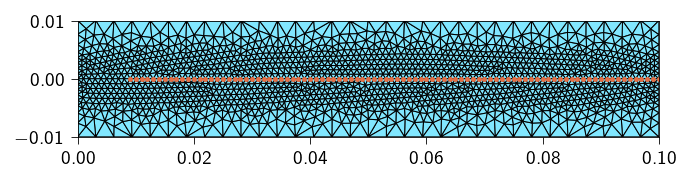

In [44]:
# | code-fold: true
# | fig-align: center

plt.style.use(STYLE_PATH)
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.tripcolor(
    *mesh.coords.T,
    mesh.elements,
    facecolors=jnp.ones(mesh.elements.shape[0]),
    edgecolors="k",
    lw=0.5,
    cmap=cmc.managua_r,
)
ax.scatter(
    mesh.coords[fracture_nodes, 0],
    mesh.coords[fracture_nodes, 1],
    color=colors.red,
    s=2,
)

ax.set_aspect("equal")
ax.margins(0.0, 0.0)
plt.show()

## Defining total energy 

We assume a linear elastic material with a linear relationship between stress and strain.

In [45]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


tri = element.Tri3()
op = Operator(mesh, tri)
mat = Material(mu=1.0, lmbda=1.0)

In [47]:
@auto_vmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.swapaxes(-1, -2))

@auto_vmap(eps=2)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(eps * sig)


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)


@jax.jit
def total_energy(u_flat):
    u = u_flat.reshape(-1, n_dofs_per_node)
    return total_strain_energy(u)


Now, we derive the functions to compute the internal forces and the stiffness matrix using automatic differentiation.

In [48]:
gradient = jax.jacrev(total_energy)
hessian = jax.jacfwd(gradient)

## Applying Dirichlet boundary conditions

We apply a prestrain to the top and bottom edges of the plate.

In [57]:
prestrain = 0.01

y_max = np.max(mesh.coords[:, 1])
y_min = np.min(mesh.coords[:, 1])
x_min = np.min(mesh.coords[:, 0])
x_max = np.max(mesh.coords[:, 0])

height = y_max - y_min
applied_displacement = prestrain * height

In [58]:


top_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_max))[0]
bottom_nodes = jnp.where(jnp.isclose(mesh.coords[:, 1], y_min))[0]
left_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], x_min))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], x_max))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * top_nodes,
        2 * top_nodes + 1,
        2 * bottom_nodes,
        2 * bottom_nodes + 1,
    ]
)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

u_target = jnp.zeros(n_dofs)
u_target = u_target.at[2 * left_nodes].set(0.0)
u_target = u_target.at[2 * top_nodes].set(0.0)
u_target = u_target.at[2 * bottom_nodes].set(0.0)
u_target = u_target.at[2 * top_nodes + 1].set(applied_displacement/2.)
u_target = u_target.at[2 * bottom_nodes + 1].set(-applied_displacement/2.)
u_target_flat = u_target.flatten()

u_init = jnp.zeros(n_dofs)
u_init = u_init.at[free_dofs].set(u_target_flat[free_dofs])

u_init_flat = u_init.flatten()

In [59]:
#| code-fold: true

def newton_solver(
    u_target_flat,
    n_steps=10,
    tol=1e-8,
    max_iter=20,
):

    du_total = u_target_flat / n_steps
    u = jnp.zeros(n_dofs)

    for step in range(n_steps):
        print(f"Step {step+1}/{n_steps}")
        u = u.at[fixed_dofs].set((step + 1) * du_total[fixed_dofs])
        for i in range(max_iter):
            res = -gradient(u)
            H = hessian(u)
            res_r = res[free_dofs]

            H_rr = H[jnp.ix_(free_dofs, free_dofs)]

            delta_u = jnp.linalg.solve(H_rr, res_r)
            u = u.at[free_dofs].add(delta_u)

            norm_res = jnp.linalg.norm(res_r)
            print(f"  Residual: {norm_res:.2e}")
            if norm_res < tol:
                print(f"  Converged in {i+1} iterations with residual {norm_res:.2e}")
                break
        else:
            print("  Did not converge!")
    return u.reshape(-1, n_dofs_per_node)

In [60]:
#| output: false
u_solution = newton_solver(u_target_flat, n_steps=5)

Step 1/5


  Residual: 5.02e-04
  Residual: 7.50e-19
  Converged in 2 iterations with residual 7.50e-19
Step 2/5
  Residual: 5.02e-04
  Residual: 8.41e-19
  Converged in 2 iterations with residual 8.41e-19
Step 3/5
  Residual: 5.02e-04
  Residual: 9.29e-19
  Converged in 2 iterations with residual 9.29e-19
Step 4/5
  Residual: 5.02e-04
  Residual: 1.01e-18
  Converged in 2 iterations with residual 1.01e-18
Step 5/5
  Residual: 5.02e-04
  Residual: 1.14e-18
  Converged in 2 iterations with residual 1.14e-18


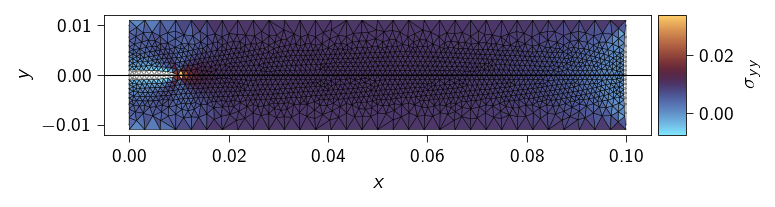

In [65]:
#| code-fold: true

from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_element_values(u, mesh, values, scale=1.0):
    displaced = mesh.coords + scale * u
    tri_elements = mesh.elements

    plt.style.use(STYLE_PATH)
    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()

    ax.triplot(
        mesh.coords[:, 0],
        mesh.coords[:, 1],
        mesh.elements,
        color="gray",
        linewidth=0.5,
    )

    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=values,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.axhline(y=0, color="black", linewidth=0.5)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_aspect("equal")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax, label=r"$\sigma_{yy}$")
    plt.show()


# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)
plot_element_values(u_solution, mesh, stresses[:, 0, 0].flatten(), scale=10.)